## Exercise 1.4 Hotdog -- no hotdog
This is the poster hand-in project for the course. Please see the associated PDF for instructions.

In [71]:
import os
import numpy as np
import glob
import PIL.Image as Image
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torchvision
import torch.optim as optim

We always check that we are running on a GPU

In [72]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("✅ The code will run on NVIDIA GPU (CUDA).")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
    print("✅ The code will run on Apple Silicon GPU (MPS).")
else:
    device = torch.device("cpu")
    print("⚠️ The code will run on CPU. If you’re in Colab, go to Edit → Notebook Settings → Hardware Accelerator → GPU.")


✅ The code will run on Apple Silicon GPU (MPS).


We provide you with a class that can load the *hotdog/not hotdog* dataset you should use from /dtu/datasets1/02516/

In [73]:
class Hotdog_NotHotdog(torch.utils.data.Dataset):
    def __init__(self, train, transform, data_path='hotdog_nothotdog'):
        'Initialization'
        self.transform = transform
        data_path = os.path.join(data_path, 'train' if train else 'test')
        image_classes = [os.path.split(d)[1] for d in glob.glob(data_path +'/*') if os.path.isdir(d)]
        image_classes.sort()
        self.name_to_label = {c: id for id, c in enumerate(image_classes)}
        self.image_paths = glob.glob(data_path + '/*/*.jpg')
        
    def __len__(self):
        'Returns the total number of samples'
        return len(self.image_paths)

    def __getitem__(self, idx):
        'Generates one sample of data'
        image_path = self.image_paths[idx]
        
        image = Image.open(image_path)
        c = os.path.split(os.path.split(image_path)[0])[1]
        y = self.name_to_label[c]
        X = self.transform(image)
        return X, y

Below is the simple way of converting the images to something that can be fed through a network.
Feel free to use something other than $128\times128$ images.

In [74]:
size = 128
train_transform = transforms.Compose([transforms.Resize((size, size)), 
                                    transforms.ToTensor()])
test_transform = transforms.Compose([transforms.Resize((size, size)), 
                                    transforms.ToTensor()])

batch_size = 64
trainset = Hotdog_NotHotdog(train=True, transform=train_transform)
train_loader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=0)
testset = Hotdog_NotHotdog(train=False, transform=test_transform)
test_loader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=0)

In [75]:
print("Size of training dataset:", len(trainset))
print("Size of test dataset:", len(testset))
# just modyfing images, not adding original images transformed

Size of training dataset: 2047
Size of test dataset: 1862


In [76]:
# Get one batch from train_loader
data_iter = iter(train_loader)
images, labels = next(data_iter)

print("Batch size:", images.size(0))

print("Image shape:", images.size())  # (batch_size, channels, height, width)

Batch size: 64
Image shape: torch.Size([64, 3, 128, 128])


Let's look at some images from our data 

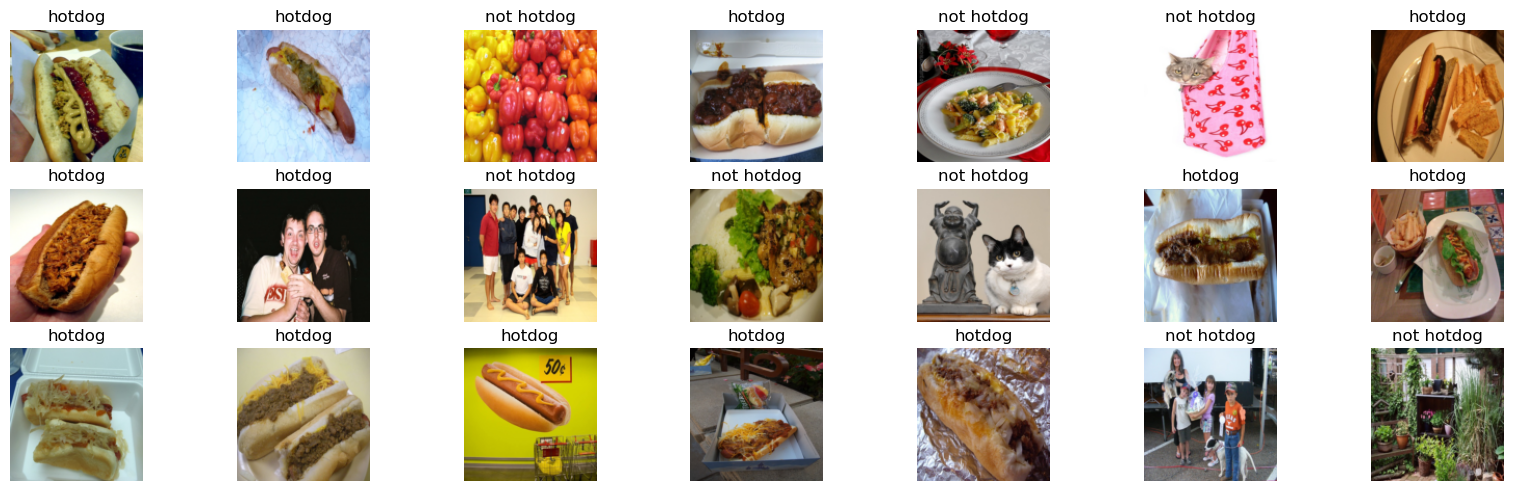

In [77]:
images, labels = next(iter(train_loader))
plt.figure(figsize=(20,10))

for i in range(21):
    plt.subplot(5,7,i+1)
    plt.imshow(np.swapaxes(np.swapaxes(images[i].numpy(), 0, 2), 0, 1))
    plt.title(['hotdog', 'not hotdog'][labels[i].item()])
    plt.axis('off')


Now create a model and train it!


In [78]:
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        self.convolutional = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout2d(0.2)
        )

        self.fully_connected = nn.Sequential(
            nn.Linear(16*16*128, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 2)
        )

    def forward(self, x):
        x = self.convolutional(x)
        x = x.view(x.size(0), -1)
        x = self.fully_connected(x)
        return x

In [79]:
model = Network()
model = model.to(device)

#Initialize the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [80]:
# Check device of model
print("Model device:", next(model.parameters()).device)

# Get one batch
data, target = next(iter(train_loader))

# Move to same device + dtype as model
data = data.to(next(model.parameters()).device).float()

print("Input shape:", data.shape, data.dtype, data.device)

# Run through conv layers
print('Shape of the output from the convolutional part:', model.convolutional(data).shape)


Model device: mps:0
Input shape: torch.Size([64, 3, 128, 128]) torch.float32 mps:0
Shape of the output from the convolutional part: torch.Size([64, 128, 16, 16])


In [81]:
num_epochs = 5

for epoch in tqdm(range(num_epochs), unit='epoch'):
    model.train()
    train_correct = 0
    
    # ---------------- TRAINING ----------------
    for minibatch_no, (data, target) in tqdm(enumerate(train_loader), total=len(train_loader)):
        # Move batch to device
        data, target = data.to(device), target.to(device)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        output = model(data)

        # Compute the loss
        loss = F.cross_entropy(output, target)

        # Backward pass
        loss.backward()

        # Update the weights
        optimizer.step()

        # Count correct predictions
        predicted = output.argmax(1)
        train_correct += (target == predicted).sum().item()

    # ---------------- EVALUATION ----------------
    model.eval()
    test_correct = 0
    incorrect_indices = []
    
    for batch_idx, (data, target) in enumerate(test_loader):
        # Move batch to device
        data, target = data.to(device), target.to(device)

        with torch.no_grad():
            output = model(data)

        predicted = output.argmax(1)
        test_correct += (target == predicted).sum().item()

        # Find incorrect predictions in this batch
        incorrect = (predicted != target).nonzero(as_tuple=True)[0]

        # Calculate global indices of incorrect predictions
        start_idx = batch_idx * batch_size
        incorrect_global_indices = (start_idx + incorrect).tolist()
        incorrect_indices.extend(incorrect_global_indices)

    # ---------------- METRICS ----------------
    train_acc = train_correct / len(trainset)
    test_acc = test_correct / len(testset)

    print("Accuracy train: {train:.1f}%\t test: {test:.1f}%".format(
        test=100*test_acc, train=100*train_acc))


  0%|          | 0/5 [00:00<?, ?epoch/s]

  0%|          | 0/32 [00:00<?, ?it/s]

Accuracy train: 53.7%	 test: 56.8%


  0%|          | 0/32 [00:00<?, ?it/s]

Accuracy train: 56.6%	 test: 62.9%


  0%|          | 0/32 [00:00<?, ?it/s]

Accuracy train: 61.2%	 test: 65.7%


  0%|          | 0/32 [00:00<?, ?it/s]

Accuracy train: 65.8%	 test: 67.0%


  0%|          | 0/32 [00:00<?, ?it/s]

Accuracy train: 70.2%	 test: 68.8%


In [82]:
torch.save(model, "model_full.pth")

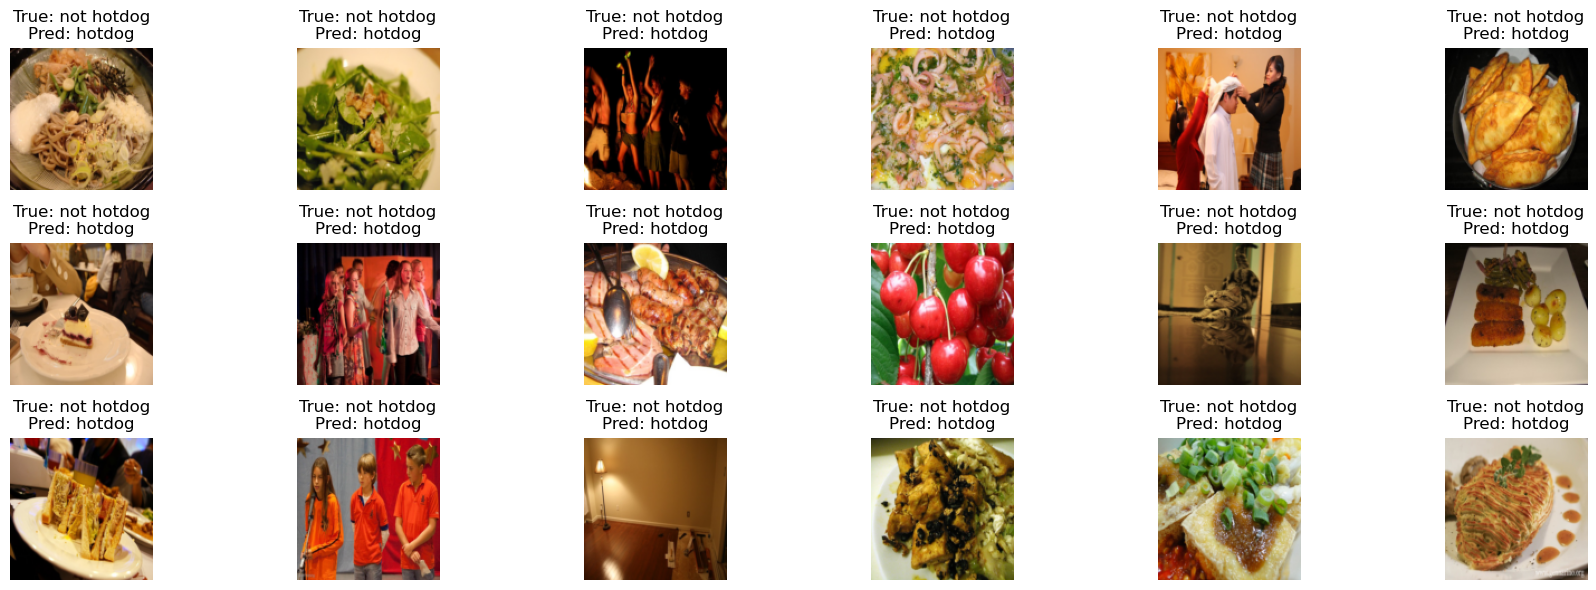

In [83]:
# Show some incorrectly predicted images from the test set
num_to_show = 18  # Number of images to display
plt.figure(figsize=(18, 6))

for idx, img_idx in enumerate(incorrect_indices[:num_to_show]):
    img, true_label = testset[img_idx]

    # Model expects batch, so add batch dimension and move to device
    img_device = img.unsqueeze(0).to(device)

    with torch.no_grad():
        pred = model(img_device).argmax(1).item()

    # Plot needs CPU numpy array, so convert back
    plt.subplot(3, 6, idx + 1)
    plt.imshow(np.transpose(img.numpy(), (1, 2, 0)))  # keep original CPU img for visualization
    plt.title(f"True: {['hotdog','not hotdog'][true_label]}\nPred: {['hotdog','not hotdog'][pred]}")
    plt.axis('off')

plt.tight_layout()
plt.show()


### Transfer learning ResNet ###

In [84]:
# ------------------------------
# Transforms (ResNet expects 224x224 + normalization)
# ------------------------------
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# ------------------------------
# Datasets & DataLoaders
# ------------------------------
train_dataset = Hotdog_NotHotdog(train=True, transform=transform, data_path="hotdog_nothotdog")
test_dataset  = Hotdog_NotHotdog(train=False, transform=transform, data_path="hotdog_nothotdog")

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=0)

# ------------------------------
# Load Pretrained ResNet18
# ------------------------------
model = torchvision.models.resnet18(pretrained=True)

# Freeze feature extractor
for param in model.parameters():
    param.requires_grad = False

# Replace classifier for 2 classes
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)

# ------------------------------
# Training Setup
# ------------------------------
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.01)
model.to(device)

# ------------------------------
# Training Loop
# ------------------------------
num_epochs = 5

for epoch in range(num_epochs):
    # ------------------ TRAIN ------------------
    model.train()
    train_correct, total = 0, 0
    
    for data, target in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Training]"):
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(output, 1)
        train_correct += (predicted == target).sum().item()
        total += target.size(0)

    train_acc = 100 * train_correct / total

    # ------------------ TEST ------------------
    model.eval()
    test_correct, test_total = 0, 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            _, predicted = torch.max(output, 1)
            test_correct += (predicted == target).sum().item()
            test_total += target.size(0)

    test_acc = 100 * test_correct / test_total

    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train Acc: {train_acc:.2f}% | Test Acc: {test_acc:.2f}%")


# ------------------------------
# Save the Model
# ------------------------------
torch.save(model.state_dict(), "resnet18_hotdog.pth")
print("Model saved to resnet18_hotdog.pth ✅")

/opt/anaconda3/envs/intro_DL_CV/lib/python3.13/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/envs/intro_DL_CV/lib/python3.13/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/5 [Training]:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch [1/5] Train Acc: 84.17% | Test Acc: 91.94%


Epoch 2/5 [Training]:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch [2/5] Train Acc: 90.82% | Test Acc: 92.96%


Epoch 3/5 [Training]:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch [3/5] Train Acc: 90.03% | Test Acc: 90.71%


Epoch 4/5 [Training]:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch [4/5] Train Acc: 93.01% | Test Acc: 91.35%


Epoch 5/5 [Training]:   0%|          | 0/64 [00:00<?, ?it/s]

Epoch [5/5] Train Acc: 92.33% | Test Acc: 93.02%
Model saved to resnet18_hotdog.pth ✅
